##  Notebook 03 de 06


(Versão, 14 de Abril de 2025)




# Detecção de Desbalanceamento em Máquinas Rotativas por meio da Análise de Sinais de Vibração utilizando Deep Learning

**Notebook usado como Referência:**

Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt. "Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data". 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Abordagem 3: CNN - Convolutional Neural Network como classificador multiclasses - 05 Classes

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import RobustScaler

## Reading Measurement Data and Preprocessing

In [ ]:
# Option a) local file contains a small subset of the entire dataset
url = '/content/gdrive/MyDrive/Base de Dados/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = False
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [ ]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

**PRÉ-TRATAMENTO DOS SINAIS**

Separação das duas sequências de aquisição de dados

In [ ]:
data0D_A = data0D.iloc[0:int(len(data0D)/2)]
data0D_B = data0D.iloc[int(len(data0D)/2):]
data0E_A = data0E.iloc[0:int(len(data0E)/2)]
data0E_B = data0E.iloc[int(len(data0E)/2):]
data1D_A = data1D.iloc[0:int(len(data1D)/2)]
data1D_B = data1D.iloc[int(len(data1D)/2):]
data1E_A = data1E.iloc[0:int(len(data1E)/2)]
data1E_B = data1E.iloc[int(len(data1E)/2):]
data2D_A = data2D.iloc[0:int(len(data2D)/2)]
data2D_B = data2D.iloc[int(len(data2D)/2):]
data2E_A = data2E.iloc[0:int(len(data2E)/2)]
data2E_B = data2E.iloc[int(len(data2E)/2):]
data3D_A = data3D.iloc[0:int(len(data3D)/2)]
data3D_B = data3D.iloc[int(len(data3D)/2):]
data3E_A = data3E.iloc[0:int(len(data3E)/2)]
data3E_B = data3E.iloc[int(len(data3E)/2):]
data4D_A = data4D.iloc[0:int(len(data4D)/2)]
data4D_B = data4D.iloc[int(len(data4D)/2):]
data4E_A = data4E.iloc[0:int(len(data4E)/2)]
data4E_B = data4E.iloc[int(len(data4E)/2):]

Descarte das amostras iniciais e finais

In [ ]:
skip = 100000
data0D_A = data0D_A.iloc[skip:-skip,:]
data0D_B = data0D_B.iloc[skip:-skip,:]
data0E_A = data0E_A.iloc[skip:-skip,:]
data0E_B = data0E_B.iloc[skip:-skip,:]
data1D_A = data1D_A.iloc[skip:-skip,:]
data1D_B = data1D_B.iloc[skip:-skip,:]
data1E_A = data1E_A.iloc[skip:-skip,:]
data1E_B = data1E_B.iloc[skip:-skip,:]
data2D_A = data2D_A.iloc[skip:-skip,:]
data2D_B = data2D_B.iloc[skip:-skip,:]
data2E_A = data2E_A.iloc[skip:-skip,:]
data2E_B = data2E_B.iloc[skip:-skip,:]
data3D_A = data3D_A.iloc[skip:-skip,:]
data3D_B = data3D_B.iloc[skip:-skip,:]
data3E_A = data3E_A.iloc[skip:-skip,:]
data3E_B = data3E_B.iloc[skip:-skip,:]
data4D_A = data4D_A.iloc[skip:-skip,:]
data4D_B = data4D_B.iloc[skip:-skip,:]
data4E_A = data4E_A.iloc[skip:-skip,:]
data4E_B = data4E_B.iloc[skip:-skip,:]

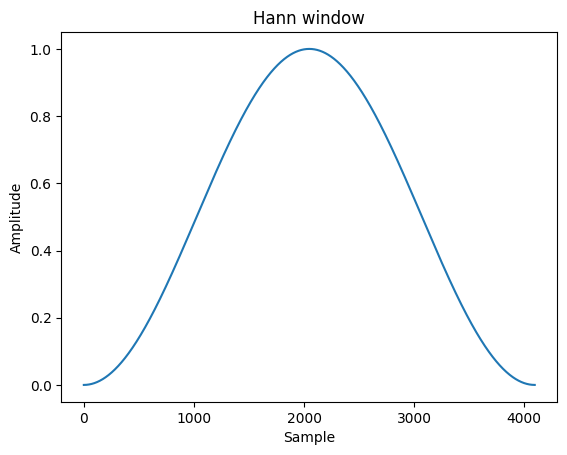

In [ ]:
window = np.hanning(4096)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

Normalização pelo quadrado da velocidade

In [ ]:
def normaliza_vibracao(basededados, sensor, quad=True):
  if quad:
    basededados[sensor] = basededados[sensor]/np.square(basededados['Measured_RPM'])
  else:
    basededados[sensor] = basededados[sensor]/basededados['Measured_RPM']
  return basededados

Função para segmentar a série temporal

In [ ]:
labels = {'Balanced' : 0.0, 'Unbalanced_LowLow' : 45.9, 'Unbalanced_Low': 60.7, 'Unbalanced_High': 75.5, 'Unbalanced_HighHigh': 152.1}

samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

Dividindo a série temporal dos dados do sensor **"Vibration_1"** em segmentos de  comprimento 4096

In [ ]:
sensor = 'Vibration_1'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_1=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_1_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
y_val = encoder.fit_transform(y_val.reshape(-1, 1))

In [ ]:
y.shape

(31736, 5)

In [ ]:
y[0]

array([1., 0., 0., 0., 0.])

In [ ]:
y_val.shape

(7932, 5)

In [ ]:
y_val[0]

array([1., 0., 0., 0., 0.])

Dividindo a série temporal dos dados do sensor **"Vibration_2"** em segmentos de  comprimento 4096

In [ ]:
'''
sensor = 'Vibration_2'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_2=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_2_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])
'''

"\nsensor = 'Vibration_2'\n\nX0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')\nX1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')\nX2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')\nX3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')\nX4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')\nX1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')\nX2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')\nX3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')\nX4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')\nX1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')\nX2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')\nX3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')\nX4_B,y4_B = get_features(data4D_B[sensor], 'Un

Dividindo a série temporal dos dados do sensor **"Vibration_3"** em segmentos de  comprimento 4096

In [ ]:
'''
sensor = 'Vibration_3'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_3=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_3_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])
'''

"\nsensor = 'Vibration_3'\n\nX0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')\nX1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')\nX2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')\nX3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')\nX4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')\nX1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')\nX2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')\nX3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')\nX4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')\nX1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')\nX2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')\nX3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')\nX4_B,y4_B = get_features(data4D_B[sensor], 'Un

Dividindo a série temporal dos dados do sensor **"Measured_RPM"** em segmentos de  comprimento 4096

In [ ]:
'''
sensor = 'Measured_RPM'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Measured_RPM=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Measured_RPM_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])
'''

"\nsensor = 'Measured_RPM'\n\nX0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')\nX1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')\nX2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')\nX3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')\nX4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')\nX1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')\nX2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')\nX3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')\nX4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')\nX1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')\nX2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')\nX3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')\nX4_B,y4_B = get_features(data4D_B[sensor], 'U

Now the dataset for training X contains 32142 samples with 4096 values each as well as the associated label information y with 32142 labels (one label per sample). The dataset for validating the trained model X_val contains 8420 samples plus the labels y_val accordingly.

In [ ]:
print(X_Vibration_1.shape, y.shape, X_Vibration_1_val.shape, y_val.shape)

(31736, 4096) (31736, 5) (7932, 4096) (7932, 5)


In [ ]:
#print(X_Vibration_2.shape, y.shape, X_Vibration_2_val.shape, y_val.shape)

In [ ]:
#print(X_Vibration_3.shape, y.shape, X_Vibration_3_val.shape, y_val.shape)

In [ ]:
#print(X_Measured_RPM.shape, y.shape, X_Measured_RPM_val.shape, y_val.shape)

**Janelamento dos sinais de vibração** (Posicionado aqui para não gerar estouro de RAM)

In [ ]:
def janelamentoHanning(basededados, window):
  janela_hanning = np.hanning(window)
  basededados = basededados*janela_hanning
  return basededados

In [ ]:
X_Vibration_1_jan = janelamentoHanning(X_Vibration_1, 4096)
X_Vibration_1_val_jan = janelamentoHanning(X_Vibration_1_val, 4096)
#X_Vibration_2_jan = janelamentoHanning(X_Vibration_2, 4096)
#X_Vibration_2_val_jan = janelamentoHanning(X_Vibration_2_val, 4096)
#X_Vibration_3_jan = janelamentoHanning(X_Vibration_3, 4096)
#X_Vibration_3_val_jan = janelamentoHanning(X_Vibration_3_val, 4096)

In [ ]:
X_Vibration_1_jan.shape

(31736, 4096)

Calculando as estatísticas da velocidade

In [ ]:
'''
X_Measured_RPM_mean = np.mean(X_Measured_RPM, axis=1)
X_Measured_RPM_mean = X_Measured_RPM_mean.reshape(X_Measured_RPM_mean.shape[0],1)
X_Measured_RPM_val_mean = np.mean(X_Measured_RPM_val, axis=1)
X_Measured_RPM_val_mean = X_Measured_RPM_val_mean.reshape(X_Measured_RPM_val_mean.shape[0],1)
'''

'\nX_Measured_RPM_mean = np.mean(X_Measured_RPM, axis=1)\nX_Measured_RPM_mean = X_Measured_RPM_mean.reshape(X_Measured_RPM_mean.shape[0],1)\nX_Measured_RPM_val_mean = np.mean(X_Measured_RPM_val, axis=1)\nX_Measured_RPM_val_mean = X_Measured_RPM_val_mean.reshape(X_Measured_RPM_val_mean.shape[0],1)\n'

In [ ]:
#X_Measured_RPM_mean.shape

**Função para cálculo da FFT**

In [ ]:
def calcula_fft(basededados, window, freq_inicio, freq_fim):
  X_fft = np.abs(np.fft.rfft(basededados, axis=1))[:,:int(window/2)]
  return X_fft[:, freq_inicio:freq_fim]

**Extrair o Módulo da FFT do sinal**

In [ ]:
freq_inicio = 0 #Hz
freq_fim = 4096 #Hz

X_Vibration_1_fft = calcula_fft(X_Vibration_1_jan, 4096, freq_inicio, freq_fim)
X_Vibration_1_val_fft = calcula_fft(X_Vibration_1_val_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_2_fft = calcula_fft(X_Vibration_2_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_2_val_fft = calcula_fft(X_Vibration_2_val_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_3_fft = calcula_fft(X_Vibration_3_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_3_val_fft = calcula_fft(X_Vibration_3_val_jan, 4096, freq_inicio, freq_fim)

## **Encaixar no código**

Definir quais sinais serão utilizados de entrada para o modelo de Machine Learning

In [ ]:
#X = np.concatenate(( X_Measured_RPM_mean, X_Vibration_1_fft), axis=1) # X_Vibration_2_fft, X_Vibration_3_fft, X_Measured_RPM_mean), axis=1)
#X_val = np.concatenate((X_Measured_RPM_val_mean, X_Vibration_1_val_fft), axis=1) # X_Vibration_2_val_fft, X_Vibration_3_val_fft, X_Measured_RPM_val_mean), axis=1)

In [ ]:
X = X_Vibration_1_fft
X_val = X_Vibration_1_val_fft

## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28562, 2048, 1) (28562, 5) (3174, 2048, 1) (3174, 5) (7932, 2048, 1) (7932, 5)


**Escalonamento**

In [ ]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train[:,:,0])
X_train = scaler.transform(X_train[:,:,0])
X_test = scaler.transform(X_test[:,:,0])
X_val = scaler.transform(X_val[:,:,0])

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28562, 2048) (28562, 5) (3174, 2048) (3174, 5) (7932, 2048) (7932, 5)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 1028
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 200 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*20,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #segunda camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #terceira camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quarta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quinta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 5, activation = 'softmax')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='min')

    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'CategoricalCrossentropy',
                       metrics = ['accuracy'])

    history = classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint])

    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

In [ ]:
nMaxConvLayers = 1

0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2040, 20)       │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2040, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2040, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1018, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1028)           │    20,931,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,167,781 (96.01 MB)

 Trainable params: 25,167,741 (96.01 MB)

 Non-trainable params: 40 (160.00 B)

Epoch 1/200
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8510 - loss: 0.3824
Epoch 1: val_loss improved from inf to 0.04074, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8511 - loss: 0.3820 - val_accuracy: 0.9811 - val_loss: 0.0407
Epoch 2/200
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9747 - loss: 0.0609
Epoch 2: val_loss improved from 0.04074 to 0.01712, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9748 - loss: 0.0607 - val_accuracy: 0.9934 - val_loss: 0.0171
Epoch 3/200
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9850 - loss: 0.0367
Epoch 3: val_loss did not improve from 0.01712
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9849 - loss: 0.0368 - val_accuracy: 0.9918 - val_loss: 0.0191
Epoch 4/200
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9880 - loss: 0.0271
Epoch 4: val_loss improved from 0.01712 to 0.01458, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9880 - loss: 0.0271 - val_accuracy: 0.9921 - val_loss: 0.0146
Epoch 5/200
442/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9920 - loss: 0.0182
Epoch 5: val_loss did not improve from 0.01458
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9920 - loss: 0.0182 - val_accuracy: 0.9899 - val_loss: 0.0260
Epoch 6/200
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9942 - loss: 0.0145
Epoch 6: val_loss improved from 0.01458 to 0.00711, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9942 - loss: 0.0145 - val_accuracy: 0.9984 - val_loss: 0.0071
Epoch 7/200
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9894 - loss: 0.0403
Epoch 7: val_loss did not improve from 0.00711
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9894 - loss: 0.0402 - val_accuracy: 0.9953 - val_loss: 0.0093
Epoch 8/200
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9953 - loss: 0.0134
Epoch 8: val_loss did not improve from 0.00711
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9954 - loss: 0.0134 - val_accuracy: 0.9962 - val_loss: 0.0077
Epoch 9/200
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0102
Epoch 9: val_loss improved from 0.00711 to 0.00340, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9961 - loss: 0.0102 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 10/200
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0037
Epoch 10: val_loss improved from 0.00340 to 0.00249, saving model to ../models/reference/cnn_1_layers.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 11/200
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9984 - loss: 0.0045
Epoch 11: val_loss did not improve from 0.00249
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 12/200
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9963 - loss: 0.0132
Epoch 12: val_loss did not improve from 0.00249
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9987 - val_loss: 0.0067
Epoch 13/200
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9981 - loss: 0.0054
Epoch 13: val_loss did not improve from 0.00249
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9981 - loss: 0.0054 - val_accuracy: 0.9965 - val_loss: 0.0094
Epoch 14/200
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0029
Epoch 14: val_loss improved from 0.

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9997 - val_loss: 5.3015e-04
Epoch 15/200
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0015
Epoch 15: val_loss did not improve from 0.00053
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9987 - val_loss: 0.0028
Epoch 16/200
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0057
Epoch 16: val_loss did not improve from 0.00053
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9982 - loss: 0.0057 - val_accuracy: 0.9994 - val_loss: 0.0017
Epoch 17/200
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5084e-05
Epoch 17: val_loss did not improve from 0.00053
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 9.4853e-05 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 18/200
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5810e-05
Epoch 18: val_loss 

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9998 - loss: 5.2168e-04 - val_accuracy: 0.9997 - val_loss: 4.1906e-04
Epoch 35/200
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3090e-05
Epoch 35: val_loss did not improve from 0.00042
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 1.3027e-05 - val_accuracy: 0.9997 - val_loss: 5.1089e-04
Epoch 36/200
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2665e-05
Epoch 36: val_loss did not improve from 0.00042
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 4.2633e-05 - val_accuracy: 0.9994 - val_loss: 9.0732e-04
Epoch 37/200
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5363e-04
Epoch 37: val_loss did not improve from 0.00042
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9999 - loss: 2.6480e-04 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 38/200
446/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.

447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 1.0000 - loss: 8.2197e-05 - val_accuracy: 1.0000 - val_loss: 1.8738e-04
Epoch 46/200
445/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0017
Epoch 46: val_loss did not improve from 0.00019
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9924 - val_loss: 0.0350
Epoch 47/200
443/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9983 - loss: 0.0054
Epoch 47: val_loss did not improve from 0.00019
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9983 - loss: 0.0054 - val_accuracy: 0.9997 - val_loss: 8.2496e-04
Epoch 48/200
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.0973e-05
Epoch 48: val_loss did not improve from 0.00019
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 6.0888e-05 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 49/200
441/447 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5321e-06
Epoch 49: v

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7384 - loss: 2.7316


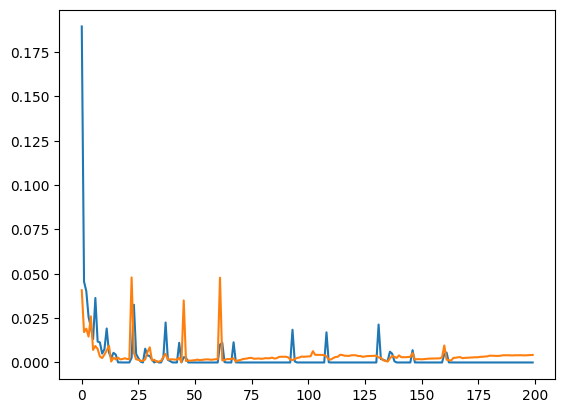

In [ ]:
if not use_reference_models:
    for i in range(1,nMaxConvLayers+1):
        train_models(i)

#### Evaluation

In [ ]:
accuracies_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    print(f"Resultados {layer_n} Conv Layers ")
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_all.append(val_acc_all)
accuracies_all = np.array(accuracies_all)

Resultados 1 Conv Layers 
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7384 - loss: 2.7316


In [ ]:
accuracies_all

array([0.7019667])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

#Predict
y_prediction = model_i.predict(X_val)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_prediction, axis=1)  # Get the index of the highest probability

# Convert y_val to class labels if it's one-hot encoded
y_true_labels = np.argmax(y_val, axis=1) # Assuming y_val is one-hot encoded

#Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='pred')

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
cm

array([[0.9187935 , 0.        , 0.        , 0.        , 0.        ],
       [0.05858469, 0.31191653, 0.433572  , 0.24949967, 0.        ],
       [0.02262181, 0.45140033, 0.566428  , 0.00733823, 0.        ],
       [0.        , 0.23668314, 0.        , 0.74316211, 0.02513795],
       [0.        , 0.        , 0.        , 0.        , 0.97486205]])

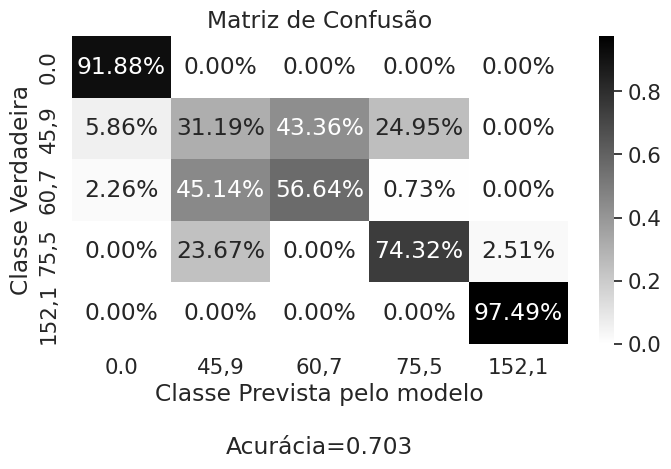

In [ ]:
import seaborn as sn

plt.figure(figsize=(8,4))
sn.set(font_scale=1.4) # for label size
#sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
accuracy  = np.trace(cm) / float(np.sum(cm))
stats_text = "\n\nAcurácia={:0.3f}".format(accuracy)
categories = ['0.0', '45,9', '60,7','75,5','152,1']

sn.heatmap(cm, annot=True,
            fmt='.2%', cmap='binary',
           xticklabels=categories,yticklabels=categories)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista pelo modelo' + stats_text)
plt.title('Matriz de Confusão')
plt.show()